# Rockfall localization

### Define Parameters

**Channel choice** *chID*: 'Z' | 'ENZ'

**Site effect deconvolution** *site_eff_deconv*: True | False

In [25]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import read, Stream
from obspy.core import UTCDateTime
from matplotlib.dates import num2date
from modules.m_PLOTS import *
from modules.m_PROB import calc_prob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### Parameters
event = '2017.022'
chID            = 'ENZ'  
site_eff_deconv = False 
lwin = 4.
swin = 2.
freqband = [13., 17.]

# Simulated domain and number of stations
xdim = 121
ydim = 101

In [3]:
if chID   == 'ENZ':
        channels = [ 'Z','N','E']
elif chID == 'Z':
        channels = [ 'Z']

10 Trace(s) in Stream:
PF.BON.00.HHZ | 2017-01-22T10:26:20.000000Z - 2017-01-22T10:27:20.000000Z | 100.0 Hz, 6001 samples
PF.BOR.00.EHZ | 2017-01-22T10:26:20.003130Z - 2017-01-22T10:27:20.003130Z | 100.0 Hz, 6001 samples
PF.DSO.90.EHZ | 2017-01-22T10:26:20.003131Z - 2017-01-22T10:27:20.003131Z | 100.0 Hz, 6001 samples
PF.SNE.00.HHZ | 2017-01-22T10:26:19.998393Z - 2017-01-22T10:27:19.998393Z | 100.0 Hz, 6001 samples
PF.BON.00.HHN | 2017-01-22T10:26:20.000000Z - 2017-01-22T10:27:20.000000Z | 100.0 Hz, 6001 samples
PF.BOR.00.EHN | 2017-01-22T10:26:20.003131Z - 2017-01-22T10:27:20.003131Z | 100.0 Hz, 6001 samples
PF.SNE.00.HHN | 2017-01-22T10:26:19.998394Z - 2017-01-22T10:27:19.998394Z | 100.0 Hz, 6001 samples
PF.BON.00.HHE | 2017-01-22T10:26:20.000000Z - 2017-01-22T10:27:20.000000Z | 100.0 Hz, 6001 samples
PF.BOR.00.EHE | 2017-01-22T10:26:20.003131Z - 2017-01-22T10:27:20.003131Z | 100.0 Hz, 6001 samples
PF.SNE.00.HHE | 2017-01-22T10:26:19.998393Z - 2017-01-22T10:27:19.998393Z | 100.0 Hz, 

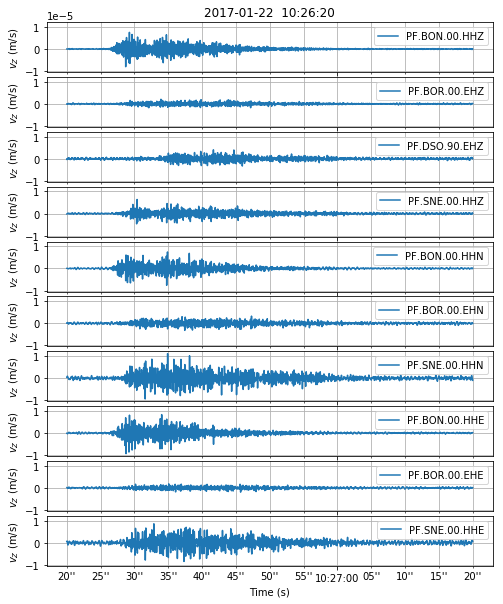

In [4]:
### LOAD EVENT DATA
st = Stream()
for ch in channels:
    st += read("data/signals/"+event+"/PF.*"+ch+".D.20*.VEL")
t0 = st[0].stats.starttime
#sig_delta = st[0].stats.delta
#sig_npts = st[0].stats.npts
eventDate = (str(t0.year)+'-'+str(t0.month).zfill(2)+'-'+str(t0.day).zfill(2)+'  '+
        str(t0.hour).zfill(2)+':'+str(t0.minute).zfill(2)+':'+str(t0.second).zfill(2))
if site_eff_deconv:
    print('Define deconvolution function')
print(st)
plot_traces(st,eventDate)

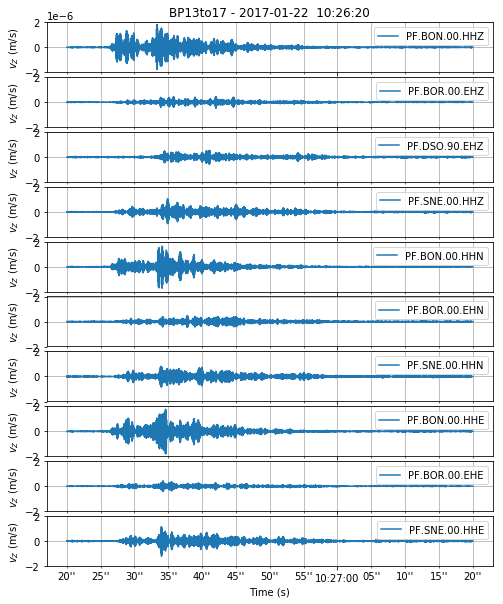

In [5]:
# Filtering
freqmin = freqband[0]
freqmax = freqband[1]
freqID  = 'BP'+str(int(freqmin))+'to'+str(int(freqmax))
st.filter('bandpass', freqmin=freqmin, freqmax=freqmax,
                    corners = 2, zerophase = 'true')
plot_traces(st,freqID+' - '+eventDate)

In [6]:
t0_UTC = UTCDateTime(t0)
t1_UTC = UTCDateTime(st[0].stats.endtime)
t0     = t0_UTC.matplotlib_date
t1     = t1_UTC.matplotlib_date

### DEFINE TIME ARRAY
offset  = (t0_UTC+swin-lwin/2) - st[0].stats.starttime
timesTW = np.array([])
for windowed_tr in st[0].slide( window_length=lwin, step=swin, offset=offset, 
                include_partial_windows=True ):
    if (windowed_tr.stats.starttime+lwin/2) > t1_UTC:
        break
    timesTW = np.append(timesTW,windowed_tr.times(type="matplotlib")[0])
nwin       = len(timesTW)
timesTW    = timesTW + lwin/2/86400. # swin (seconds) divided by number of seconds of a whole day
timesTWUTC = num2date(timesTW)
for ii in range(np.shape(timesTWUTC)[0]):
    timesTWUTC[ii] = UTCDateTime(timesTWUTC[ii])

In [15]:
probs = np.zeros((ydim,xdim))
times = np.zeros((ydim,xdim))

for iTW, windowed_st in enumerate( st.slide(window_length=lwin, 
                                            step=swin,
                                            offset=offset, 
                                            include_partial_windows=True )):
    #if iTW > setTW[-1]:
    #    break
    if (windowed_st[0].stats.starttime+lwin/2) > t1_UTC:
        break
                    
    t_curr = (windowed_st[0].stats.starttime+lwin/2).matplotlib_date
    t_currUTC = (windowed_st[0].stats.starttime+lwin/2).strftime("%H:%M:%S")
    if iTW == 0:#twtotal[0]:
        tstart = t_curr
    #if iTW == twtotal[1]:
    #    tend = t_curr
                
    probs_tw = calc_prob(windowed_st, channels, ydim, xdim, freqID)
                               
    #if iTW >= twtotal[0] and iTW <= twtotal[1]:
    if iTW == 0: #twtotal[0]:
        t_rel = 0.
        times[:,:] = t_rel
        probs = 1./(probs_tw/len(channels))
    else:
        t_rel += swin
        for ii in range(ydim):
            for jj in range(xdim):
                probs_curr = 1./(probs_tw[ii,jj]/len(channels)) 
                if probs[ii,jj] < probs_curr:
                    times[ii,jj] = t_rel
                    probs[ii,jj] = probs_curr
tend = t_curr

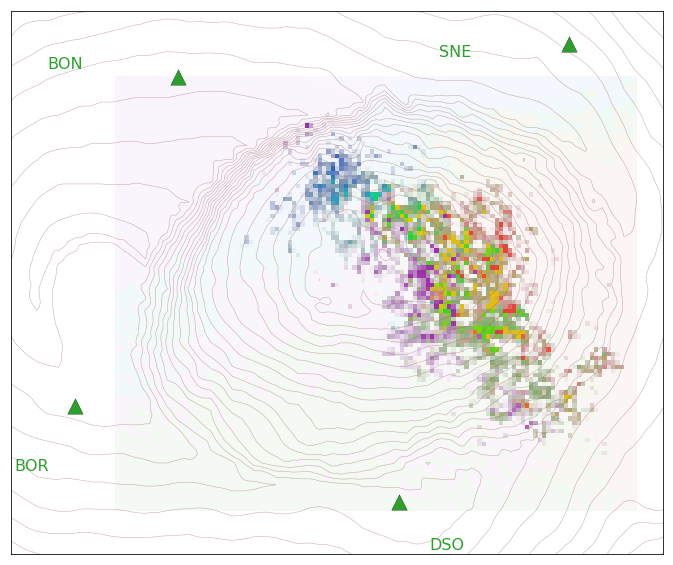

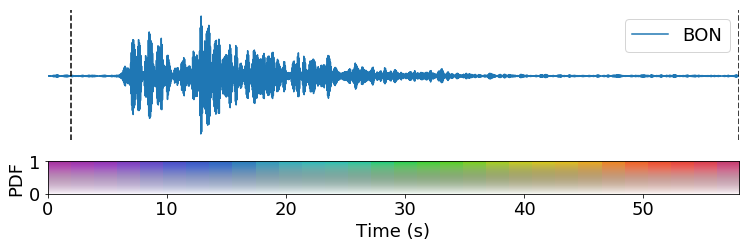

In [31]:
loc_prob_time   = np.array([np.flipud(times), np.flipud(probs)/10.])

plot_LOCA(loc_prob_time, t_rel, tstart, tend, swin)
plot_Tr_Cb(st.select(station='BON',channel='*Z')[0], tstart, tend, t_rel, swin)